# Download and Clean Chandra data for A2597
#### Osase Omoruyi & Grant Tremblay, Center for Astrophysics | Harvard & Smithsonian

This notebook *requires* that it be run either in a [CIAO Conda Environment](https://cxc.cfa.harvard.edu/ciao/threads/ciao_install_conda/), or, if you've [installed](https://cxc.cfa.harvard.edu/ciao/threads/ciao_install_tool/) `CIAO` with the `ciao-install` script, by running this notebook within `CIAO`'s Python stack. In other words, you either must run

```
conda activate ciao-4.16
```

or 

```
source /path/to/ciao/bin/ciao.sh
```

before launching this notebook (by running `jupyter notebook` or `jupyter lab`, or launching the Notebook within VS Code, etc.).

This notebook can also only be run in a directory with `no spaces`. The data analysis was performed using ciao-4.16.

In [1]:
#imports
import os
import glob

import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import simple_norm

import pyregion

import ciao_contrib.runtool as ciao
import lightcurves as lc


### Functions we'll use throughout

In [2]:
def pyregion_color(shape, saved_attrs):
    attr_list, attr_dict = saved_attrs
    attr_dict["color"] = "green"
    kwargs = pyregion.mpl_helper.properties_func_default(shape, (attr_list, attr_dict))

    return kwargs

def ds9(img, regions=None):

    '''Launch a ds9 window with the given image (and region file, if specified)'''

    if regions is None:
        command = f'ds9 {img} -cmap Magma'
    else:
        command = f'ds9 {img} -cmap Magma -regions {regions}'

    os.system(command)

### Paths Needed

In [3]:
# To allow us to cwd back to the Notebook's directory anytime
notebook_home_dir = os.getcwd()
print(f'This Notebook lives in {notebook_home_dir}')

# Directory where we'd like to place all the data and products
starting_dir = '/Users/osaseomoruyi/research/a2597/chandra/'

#now create folders to organize the data
obsID_dir = os.path.join(starting_dir, 'obsIDs/')
joint_analysis_dir = os.path.join(starting_dir, 'joint_analysis/')

if not os.path.exists(obsID_dir):
    os.makedirs(obsID_dir)
    print(f'Made directory {obsID_dir}')
else:
    print(f'Directory {obsID_dir} already exists')

if not os.path.exists(joint_analysis_dir):
    os.makedirs(joint_analysis_dir)
    print(f'Made directory {joint_analysis_dir}')
else:
    print(f'Directory {joint_analysis_dir} already exists')


This Notebook lives in /Users/osaseomoruyi/github_repos/chandraA2597/abell_2597_chandra


### Critical Parameters for Abell 2597

These numbers were obtained from the CCCPIV (Vikhlinin & Tremblay in prep) fit to A2597

In [4]:
redshift = 0.0821
nH = 2.252e+20 # % (HI4PI)   DL,LAB: 2.500e+20 2.515e+20
kT_guess = 4.0 # keV
abundance_guess = 0.4
r500 = 904.8 # kpc This is R_500_Y from Vikhlinin et al.
r500_err = 2.4 #
m500 = 2.279e14 # Msol This is M_500_Y from Vikhlinin et al.
m500_err = 1.797e12

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).to(u.kpc / u.arcsec)
print(f'At a redshift of {redshift}, we have {np.round(kpc_per_arcsec,4)}')

r500_arcsec = r500 / kpc_per_arcsec.value
r500_arcsec
print(f'The CCCPIV R_500_Y is {r500} kpc or {np.round(r500_arcsec,4)} arcsec')

At a redshift of 0.0821, we have 1.5458 kpc / arcsec
The CCCPIV R_500_Y is 904.8 kpc or 585.3442 arcsec


#### *Chandra* ObsIDs for all A2597 observations

See Table 1 in Omoruyi et al (2025)

In [5]:
obsids = [ # '922', # 922 is in FAINT mode and has a terrible flare; decided to ditch it
          '6934', # 56.0 ksec, Clarke ACIS-S3 VFAINT
          '7329', # 60.11 ksec, Clarke ACIS-S3 VFAINT
          '19596', # 69.39 ksec, Tremblay ACIS S3 VFAINT
          '19597', # 44.52 ksec, Tremblay ACIS S3 VFAINT
          '19598', # 14.34 ksec, Tremblay ACIS S3 VFAINT
          '20626', # 24.73 ksec, Tremblay ACIS S3 VFAINT
          '20627', # 20.85 ksec, Tremblay ACIS S3 VFAINT
          '20628', # 10.92 ksec, Tremblay ACIS S3 VFAINT
          '20629', # 56.36 ksec, Tremblay ACIS S3 VFAINT
          '20805', # 53.4 ksec, Tremblay ACIS S3 VFAINT
          '20806', # 37.62 ksec, Tremblay ACIS S3 VFAINT
          '20811', # 79.85 ksec, Tremblay ACIS S3 VFAINT
          '20817'] # 62.29 ksec, Tremblay ACIS S3 VFAINT


## Download the *Chandra* Data

This will take a while because it's 13 or so ObsIDs. Note that I include a check to see if that ObsID already exists (i.e. has already been downloaded) to save wasted time. 

In [10]:
downloaded_obsids = True

In [12]:
if downloaded_obsids is True:
    print('We have already downloaded the data for each ObsID')

else:
    os.chdir(obsID_dir) # Make sure data is downloaded to the right place

    for obsid in tqdm(obsids):
        if not os.path.exists(f'./{obsid}'):
            os.system(f'download_chandra_obsid {obsid} --exclude vvref')

        else:
            print(f'ObsID {obsid} looks like it has already been downloaded')


We have already downloaded the data for each ObsID


### Reprocess the data

we'll `store these, and all remaining products in the joint analysis folder`

In [15]:
for obsid in tqdm(obsids):

    if not os.path.exists(os.path.join(joint_analysis_dir, f'{obsid}_repro_evt2.fits')):
        print(f'Reprocessing {obsid} with chandra_repro and writing to {joint_analysis_dir}')
        ciao.chandra_repro(obsid, verbose=5, outdir=joint_analysis_dir, root=f'{obsid}', clobber=True, cleanup=True)
    else:
        print(f'It looks like {obsid} has already been reprocessed!')

  0%|          | 0/13 [00:00<?, ?it/s]

Reprocessing 6934 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/
Reprocessing 7329 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/
Reprocessing 19596 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/
Reprocessing 19597 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/
Reprocessing 19598 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/
Reprocessing 20626 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/
Reprocessing 20627 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/
Reprocessing 20628 with chandra_repro and writing to /Users/osaseomoruyi/research/a2597/chandra/car

### Now let's filter  the lightcurves

*Chandra* light curves track X-ray counts over time. Flares are sudden spikes in count rate caused by cosmic rays or solar activity, not real astrophysical variability.

Filtering is crucial because:
- Flares artificially boost X-ray counts, skewing spectra and surface brightness profiles.
- Flares vary across ObsIDs, so each light curve must be checked individually.

Thankfully, CIAO’s lc_sigma_clip removes any out of the ordinary spikes in the number of counts.

#### Run the `lc_sigma_clip` routine to generate new GTI (Good Time Interval) files

In [17]:
#create lc sigma clip figure folder path
lc_sigma_clip_figures = os.path.join(joint_analysis_dir, 'lc_sigma_clip_figures')
if not os.path.exists(lc_sigma_clip_figures):
    os.makedirs(lc_sigma_clip_figures)
    print(f'Made directory {lc_sigma_clip_figures}')
else:
    print(f'Directory {lc_sigma_clip_figures} already exists')

Made directory /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/lc_sigma_clip_figures


In [ ]:
#list of all reprojected evt files
repro_evt_list = glob.glob(os.path.join(joint_analysis_dir,'*repro_evt2*'))

Parameters used to clean the lightcurve are:
  script version = 16 May 2023
  clipping       = symmetric
  sigma          = 3
  minlength      = 3
  outfile        = 19596_lcclip.gti
  plot           = True
  rateaxis       = y
  color          = lime
  pattern        = solid
  pattern color  = red

Total number of bins in lightcurve   = 363
Max length of one bin                = 197.387 s
Num. bins with a smaller exp. time   = 3
Num. bins with exp. time = 0         = 10
Number of bins with a rate of 0 ct/s = 11

Rate filter:  2.5594300656786055 <= count_rate < 3.374055641243846
Mean level of filtered lightcurve = 2.9667428534612257 ct/s

GTI limits calculated using a count-rate filter:
  (count_rate>2.5594300656786055 && count_rate<3.374055641243846)

The corresponding times are:
  ((time >= 623894376.82608) && (time < 623964776.82608)) ; 69.39 ksec, bin 1

  Exposure time of lightcurve = 69.39 ks
  Filtered exposure time      = 69.39 ks
  DTCOR value                 = 0.986934

Creat

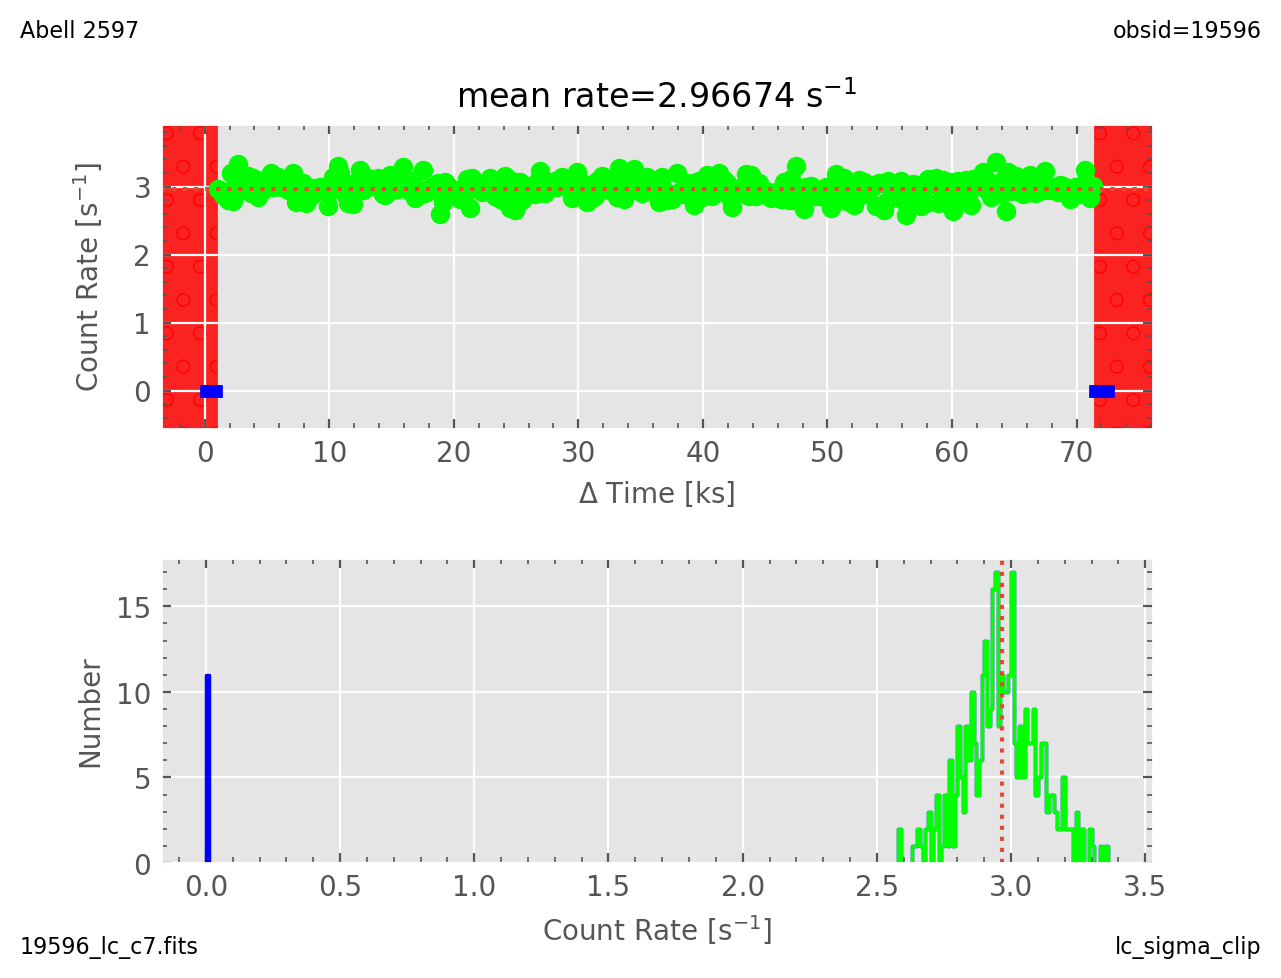

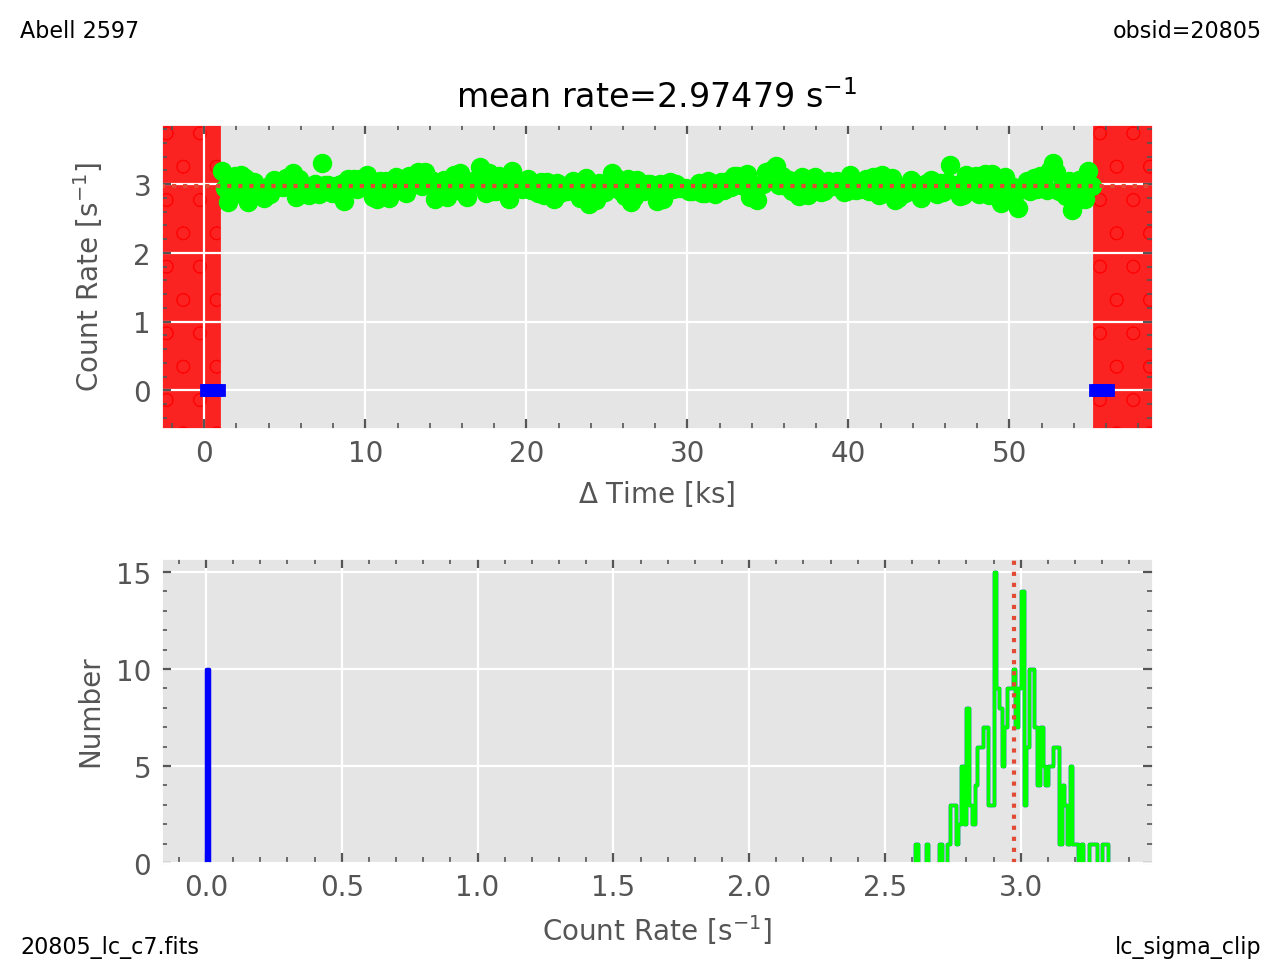

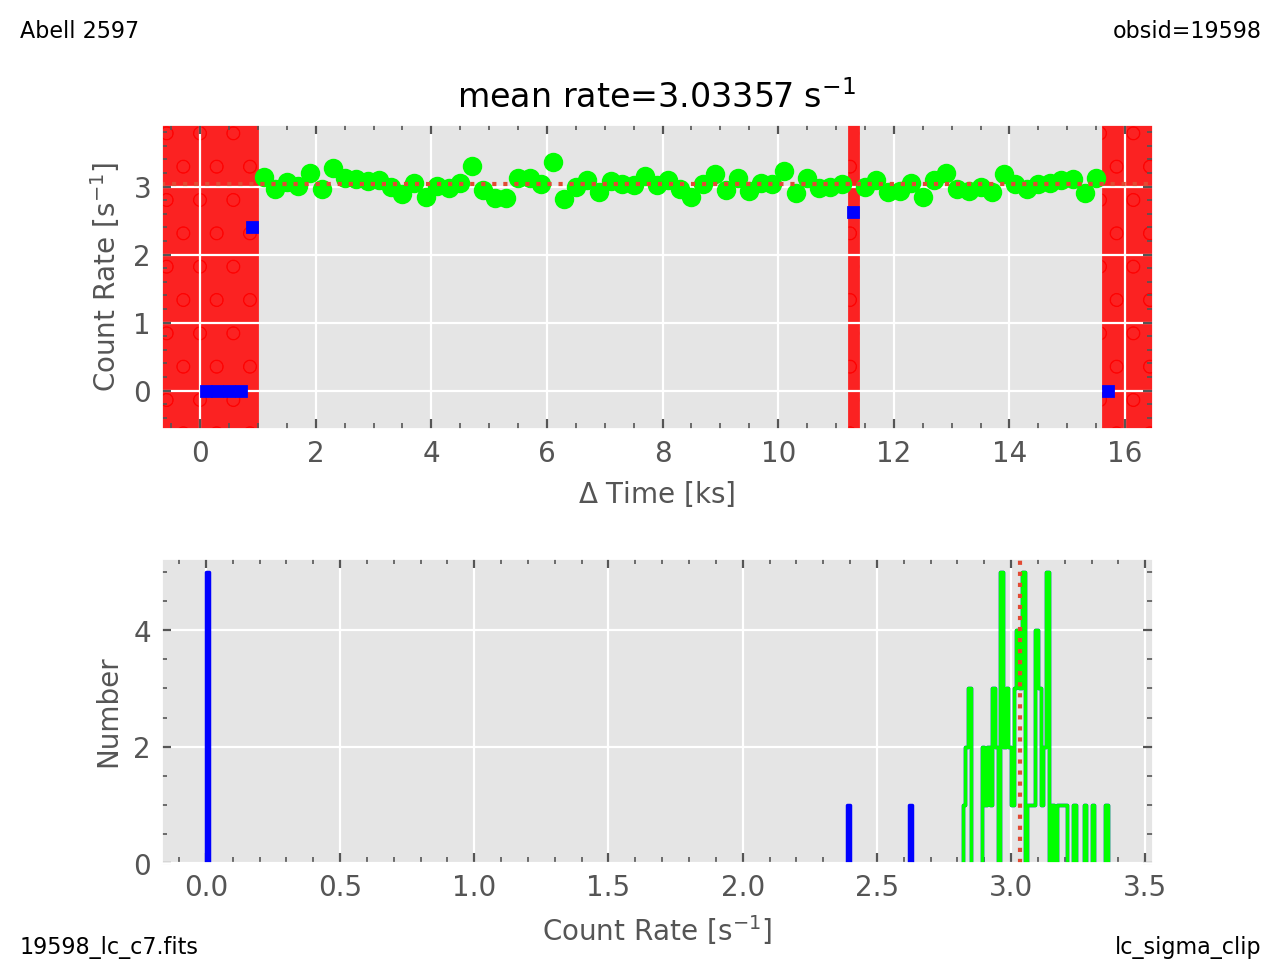

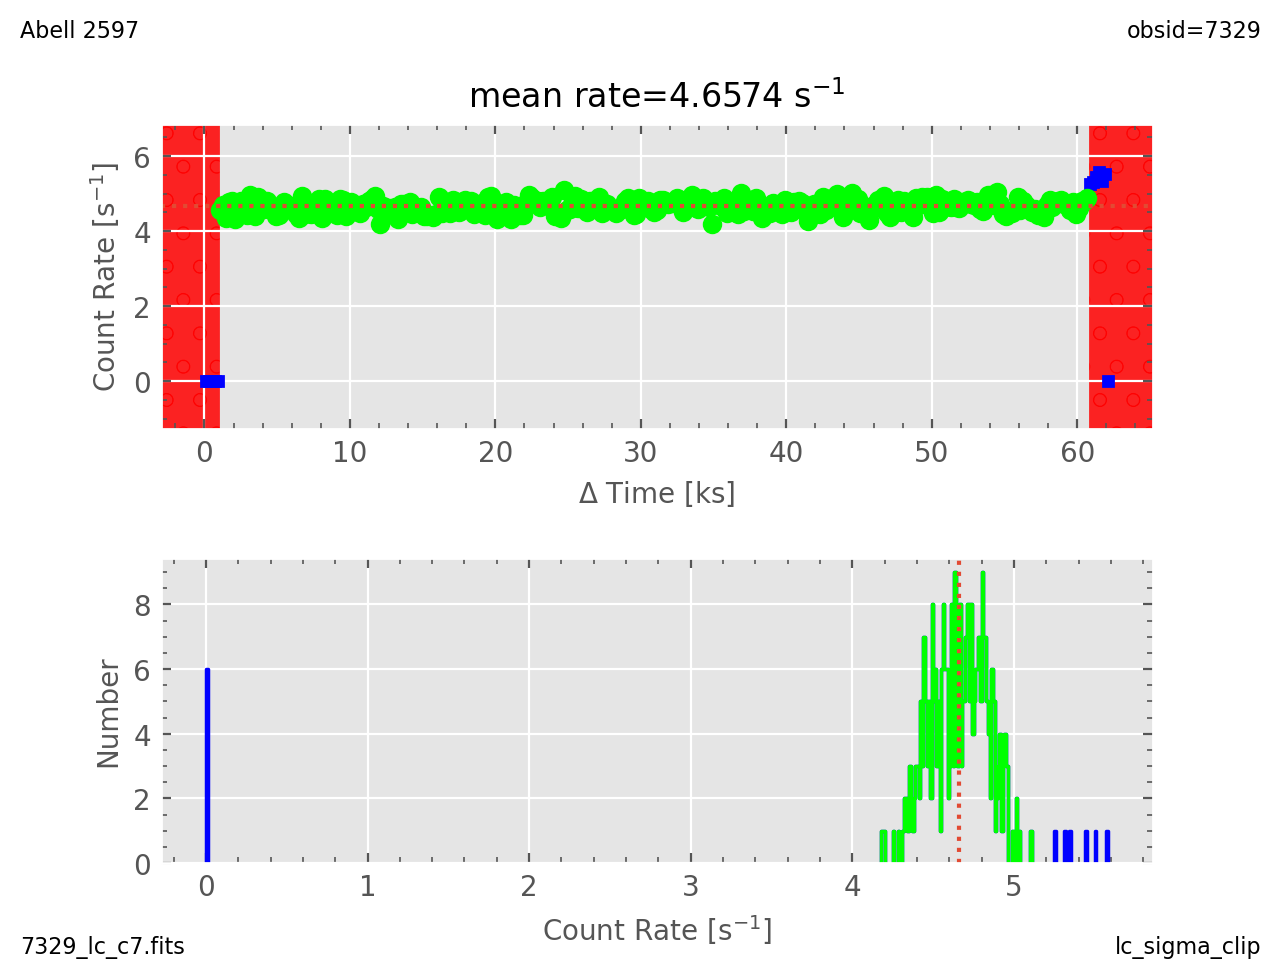

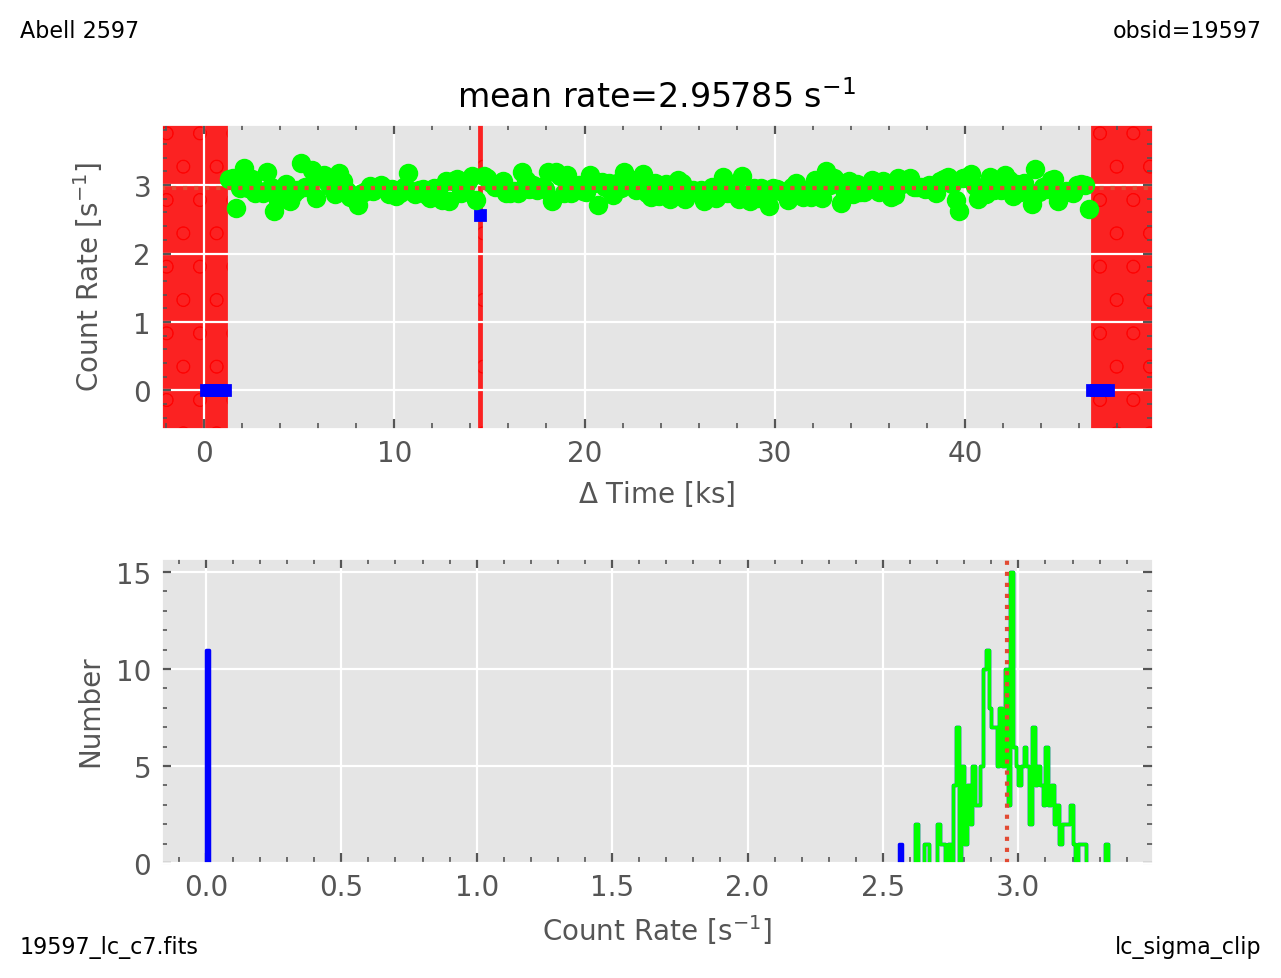

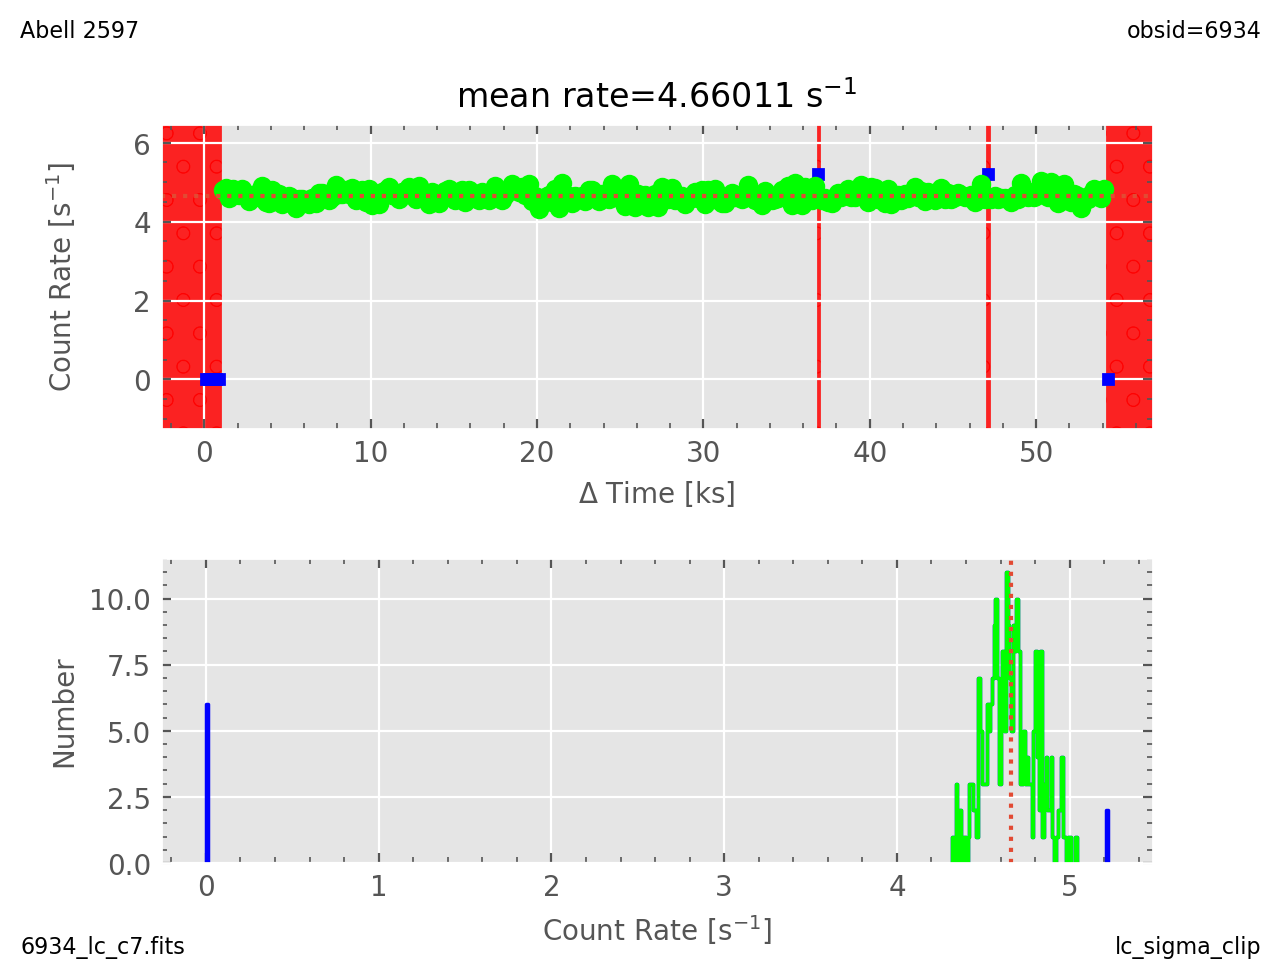

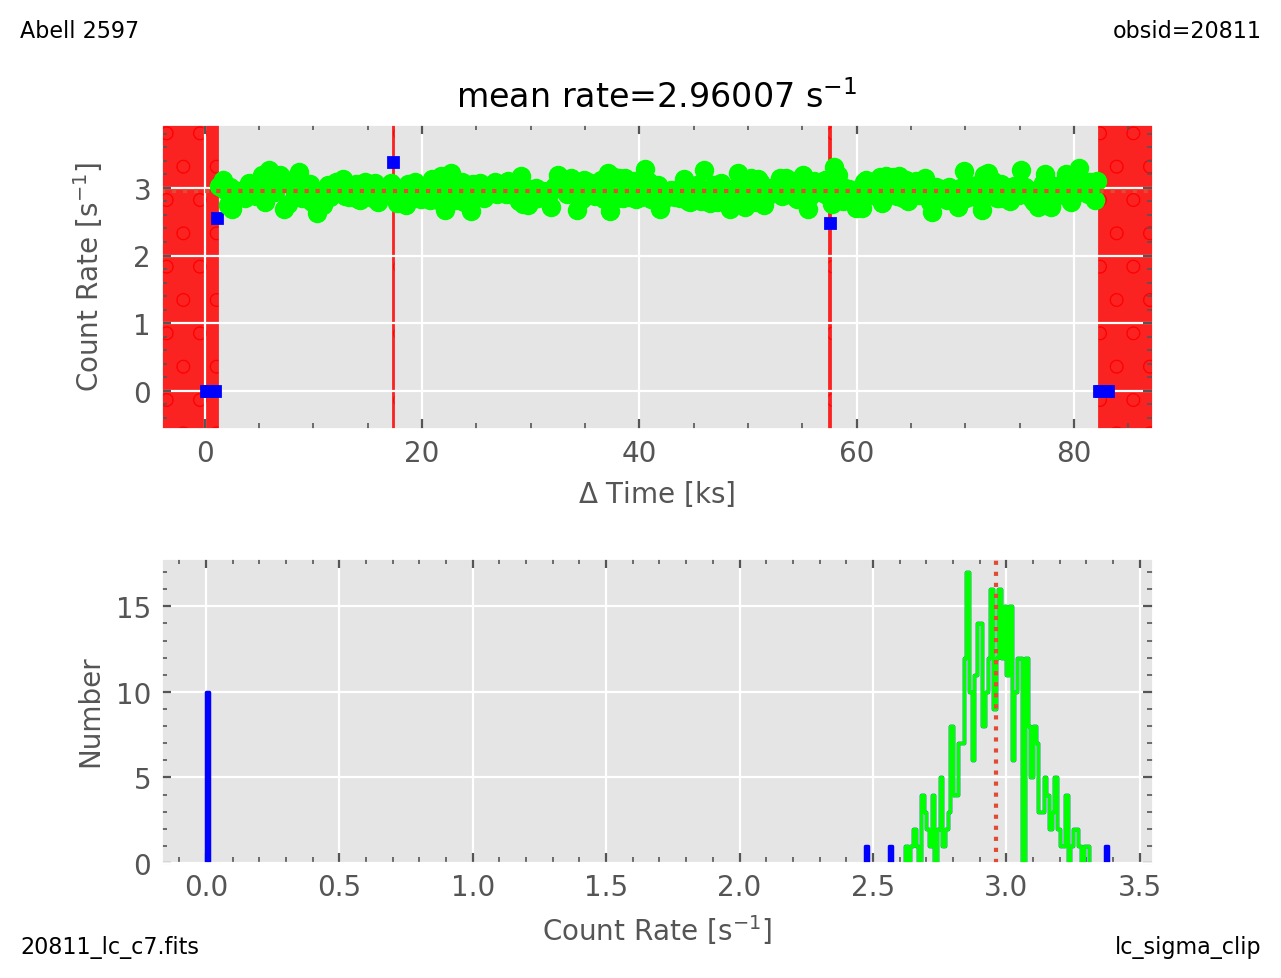

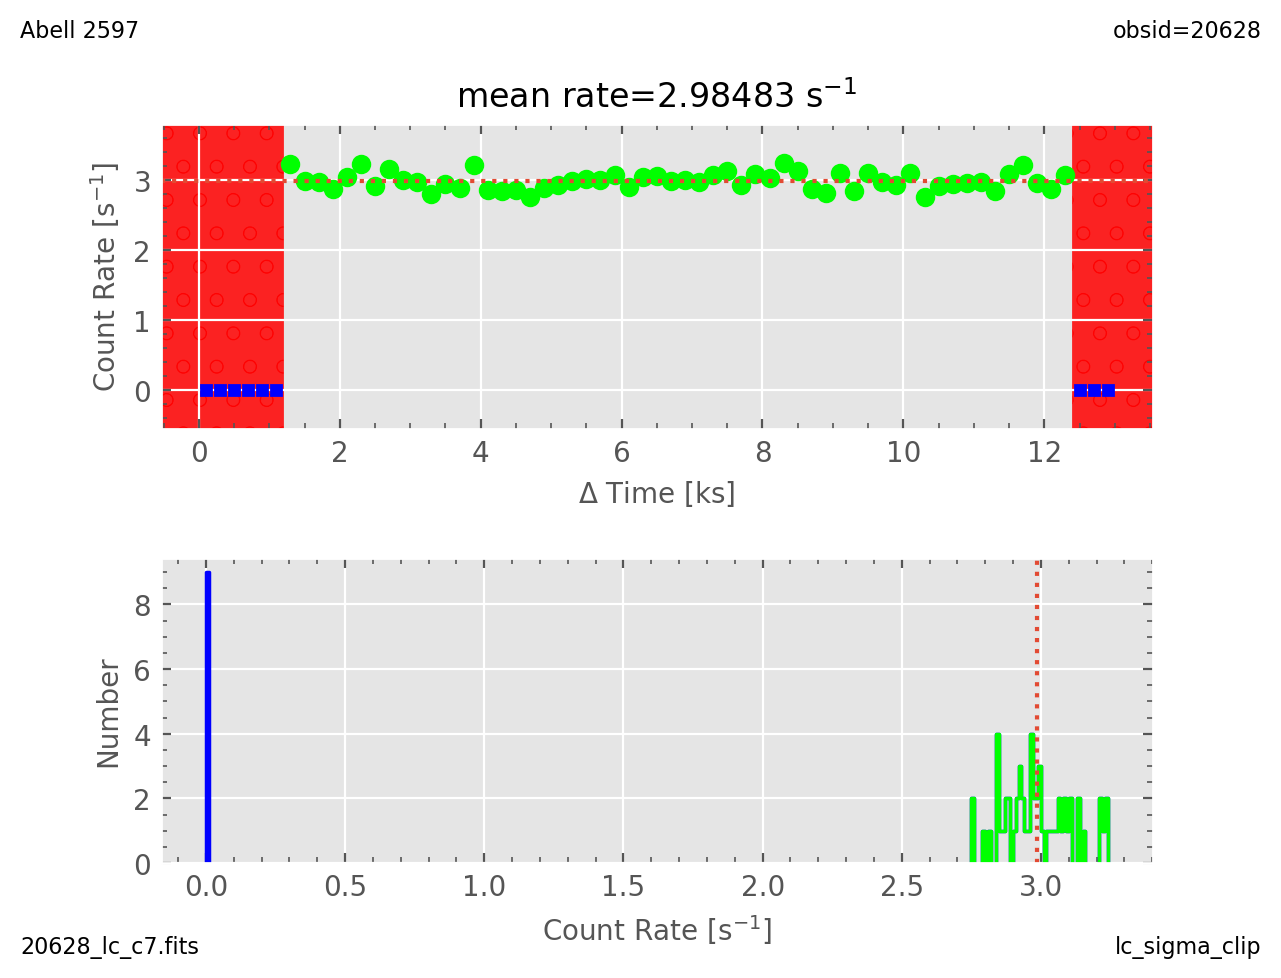

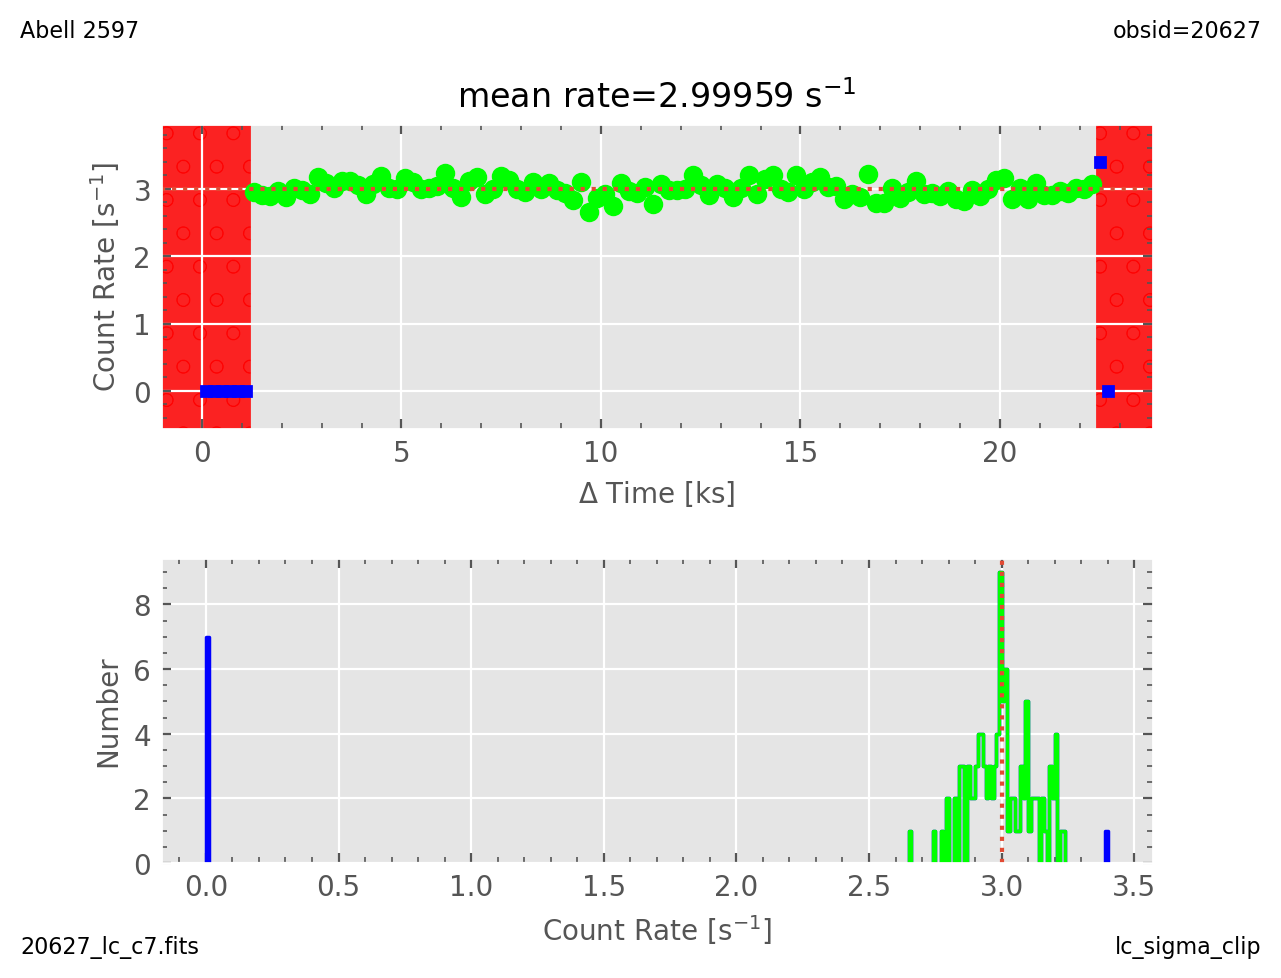

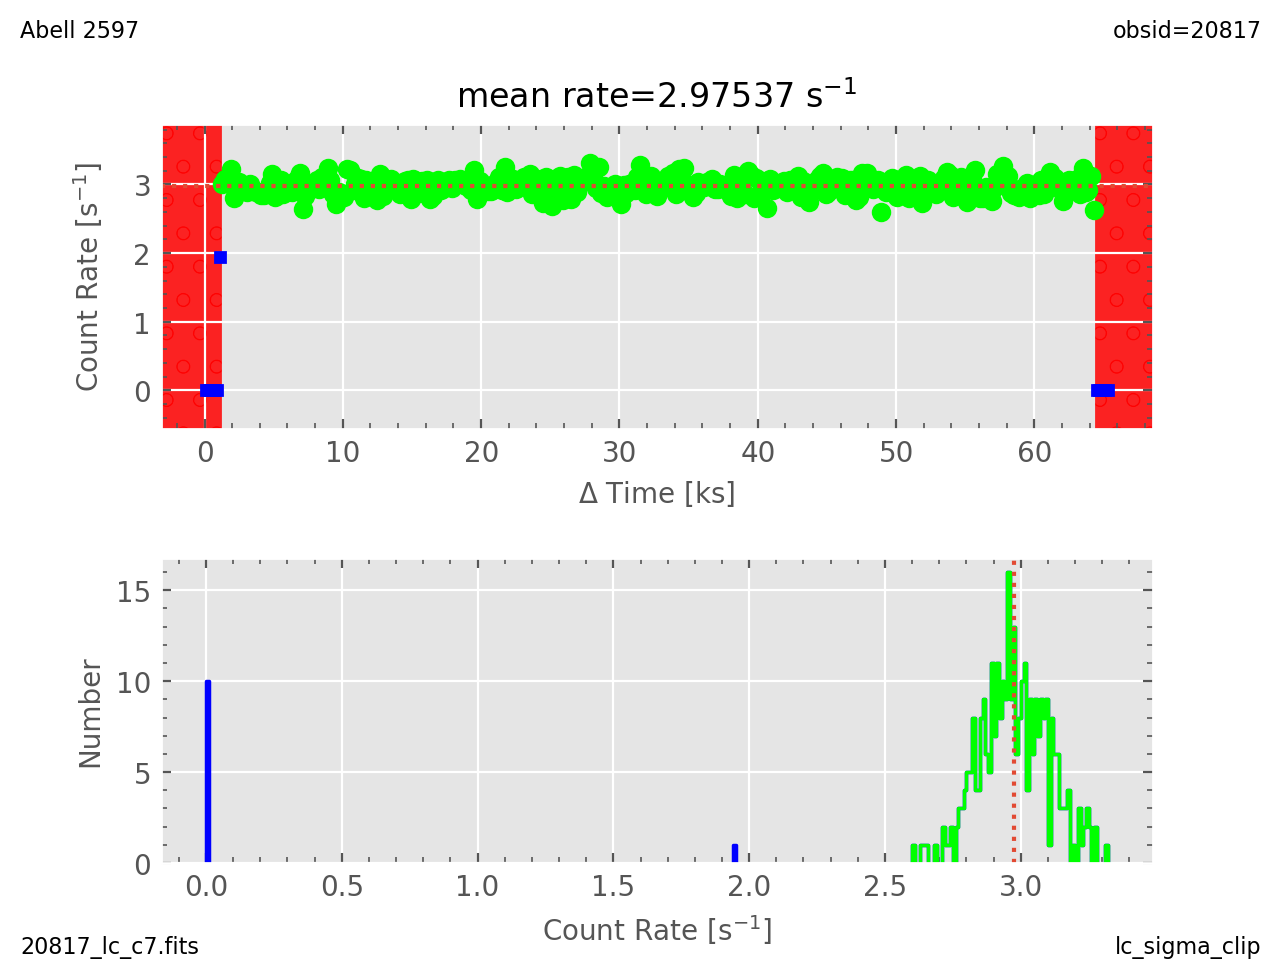

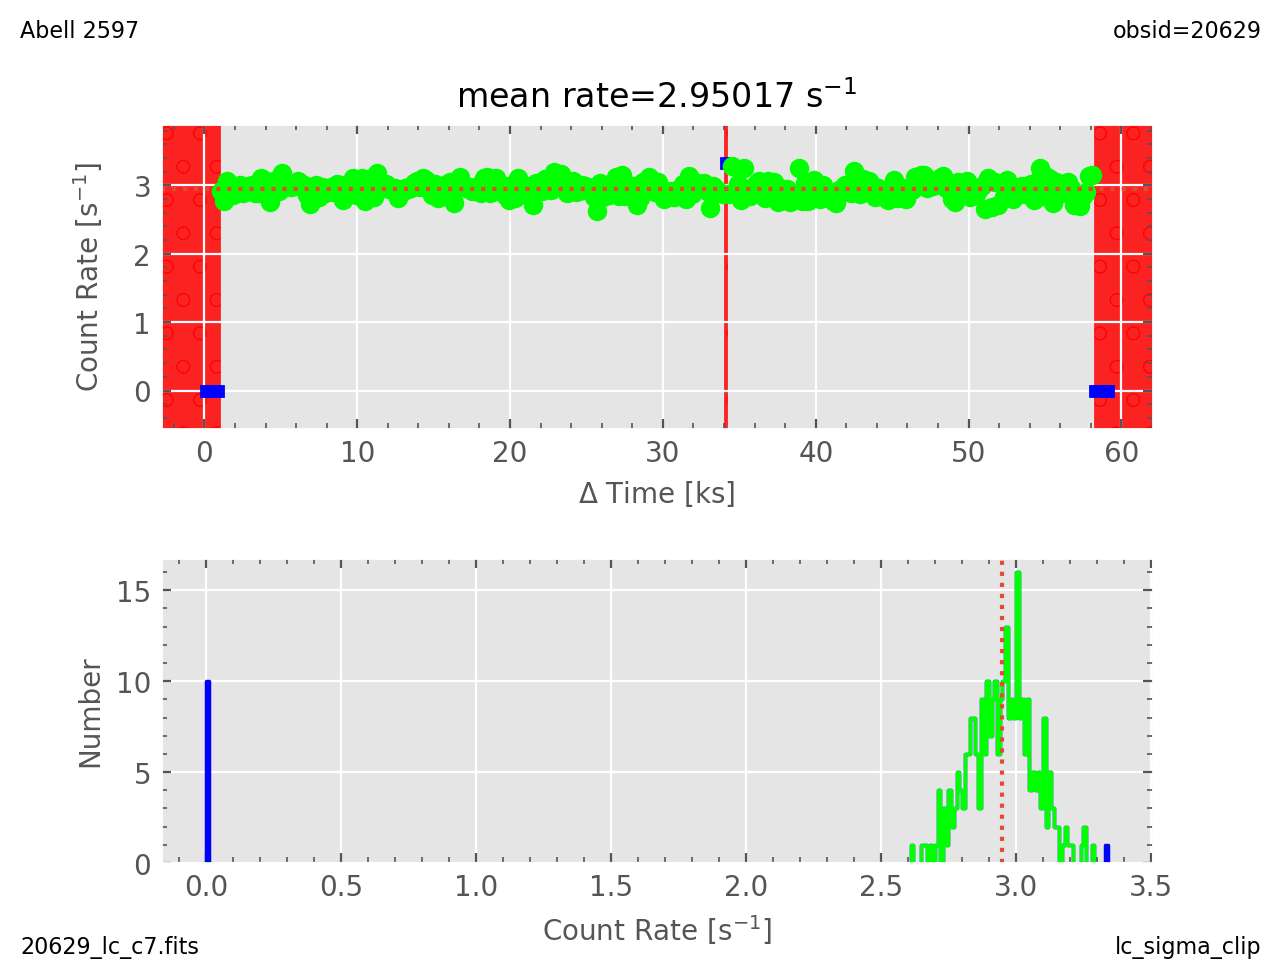

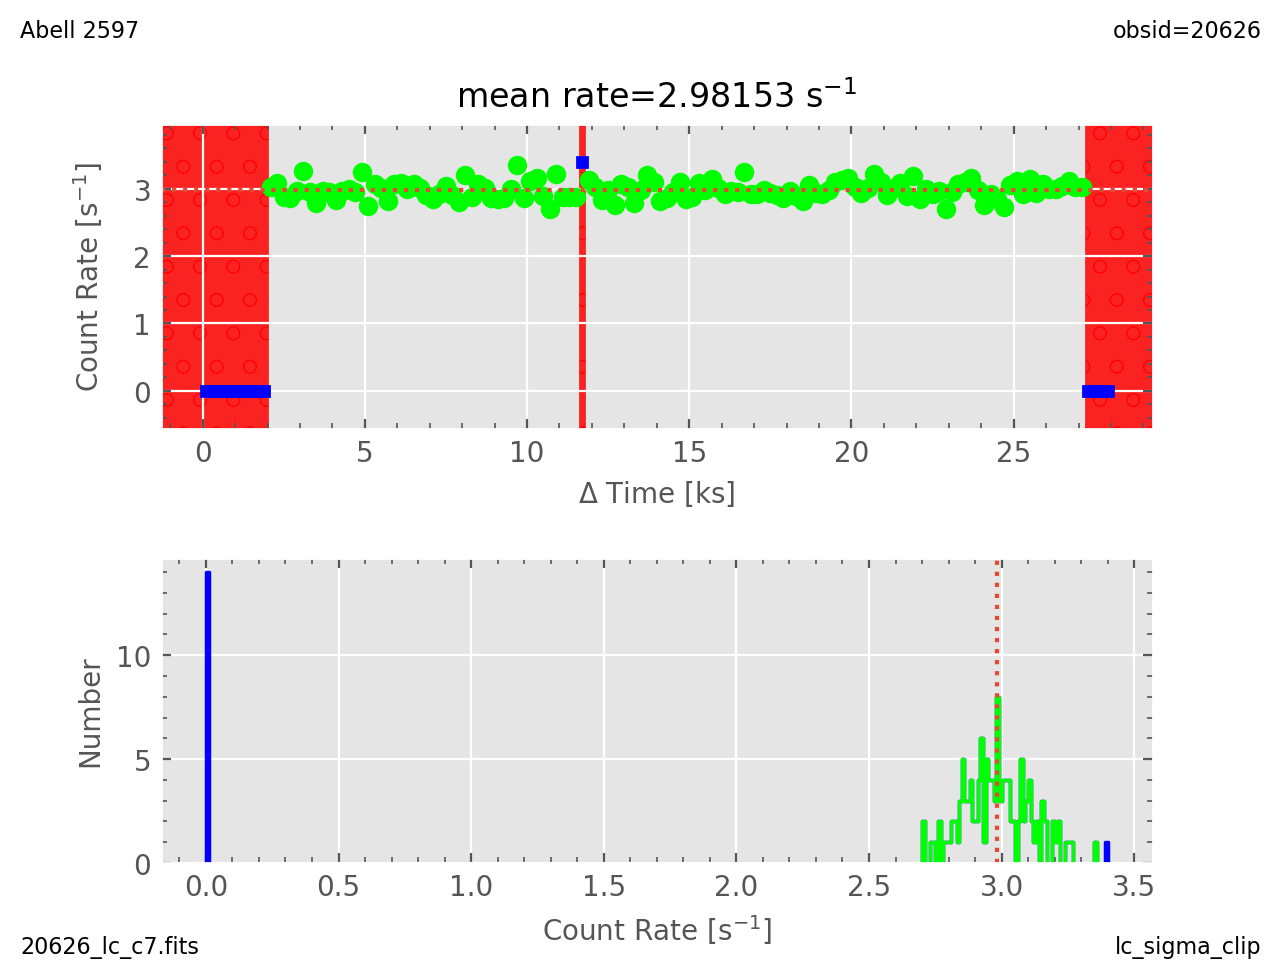

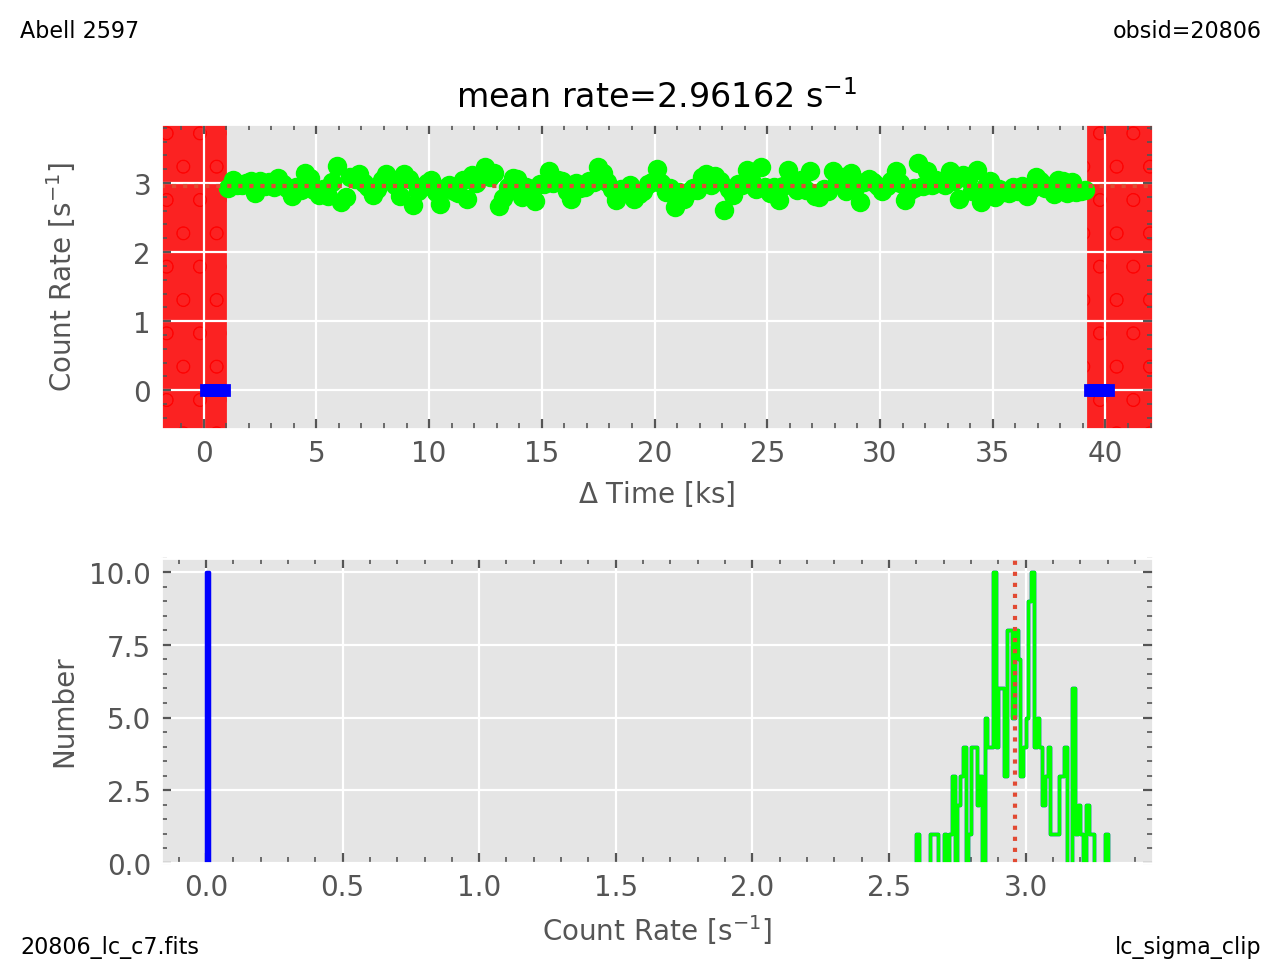

In [19]:
ciao.dmcopy.punlearn()

for evtfile in repro_evt_list:
    obsid = fits.getheader(evtfile)['OBS_ID']
    ciao.dmcopy(f"{evtfile}[energy=500:7000,ccd_id=7]", f"{obsid}_evt2_c7.fits", clobber=True)
    ciao.dmextract(f"{obsid}_evt2_c7.fits[bin time=::200]", f"{obsid}_lc_c7.fits", opt='ltc1', clobber=True)
    lc.lc_sigma_clip(f"{obsid}_lc_c7.fits", outfile=f"{obsid}_lcclip.gti", plot=True)
    plt.savefig(f'{lc_sigma_clip_figures}/{obsid}_lcclip.pdf', dpi=150)

We want to inspect all of these to ensure that (a) no obvious flare was missed, and (b) the mean count rates are *roughly* consistent. 

They're all roughly consistent, with very little time, **2.8 ks total**, flagged as bad (red) so no need to throwaway a bunch of time! Woohoo!

### Create filtered event files using our new GTI files

In [20]:
for evtfile in tqdm(repro_evt_list):
    obsid = fits.getheader(evtfile)['OBS_ID']
    print(f'Flare cleaning {obsid}. Creating {obsid}_repro_flarecleaned_evt2.fits')
    ciao.dmcopy(f'{obsid}_repro_evt2.fits[@{obsid}_lcclip.gti]', f'{obsid}_repro_flarecleaned_evt2.fits', clobber=True)

print('Done.')

  0%|          | 0/13 [00:00<?, ?it/s]

Flare cleaning 19596. Creating 19596_repro_flarecleaned_evt2.fits
Flare cleaning 20805. Creating 20805_repro_flarecleaned_evt2.fits
Flare cleaning 19598. Creating 19598_repro_flarecleaned_evt2.fits
Flare cleaning 7329. Creating 7329_repro_flarecleaned_evt2.fits
Flare cleaning 19597. Creating 19597_repro_flarecleaned_evt2.fits
Flare cleaning 6934. Creating 6934_repro_flarecleaned_evt2.fits
Flare cleaning 20811. Creating 20811_repro_flarecleaned_evt2.fits
Flare cleaning 20628. Creating 20628_repro_flarecleaned_evt2.fits
Flare cleaning 20627. Creating 20627_repro_flarecleaned_evt2.fits
Flare cleaning 20817. Creating 20817_repro_flarecleaned_evt2.fits
Flare cleaning 20629. Creating 20629_repro_flarecleaned_evt2.fits
Flare cleaning 20626. Creating 20626_repro_flarecleaned_evt2.fits
Flare cleaning 20806. Creating 20806_repro_flarecleaned_evt2.fits
Done.


In [21]:
cleaned_repro_evt_list = glob.glob(os.path.join(joint_analysis_dir,'*repro_flarecleaned_evt2*'))

print("The flare-cleaned event lists, which we will do ALL ANALYSIS ON, are:")
cleaned_repro_evt_list

The flare-cleaned event lists, which you should do ALL ANALYSIS ON, are:


['/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/19597_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/7329_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/20806_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/20805_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/20628_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/20626_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/20627_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/20629_repro_flarecleaned_evt2.fits',
 '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/20811_repro_

### Merge the ObsIDs
This can take a while, depending on the binning factor

#### Create merged images with different bins

In [23]:
merged_out_folder = os.path.join(joint_analysis_dir, 'merged')
if not os.path.exists(merged_out_folder):
    os.makedirs(merged_out_folder)
    print(f'Made directory {merged_out_folder}')
else:
    print(f'Directory {merged_out_folder} already exists')

binning_factors = [0.5, 1.0, 2.0, 4.0, 8.0] # the binning factor for merge_obs. CRITICAL that this is saved, because we later use it for make_region_files

evtfiles_to_merge = cleaned_repro_evt_list 

for binning_factor in binning_factors:
    print('************************************************')
    print(f'Merging with binning factor {binning_factor}')
    print('************************************************')

    ciao.merge_obs.punlearn() # Usually useful to do this because CIAO parameters get set and remembered until you explicitly change them!
    ciao.merge_obs(evtfiles_to_merge, bands='broad,csc', bin=binning_factor, verbose=1, 
                   clobber=True, psfecf=0.9, psfmerge='exptime', outroot=f'merged/bin{binning_factor}_')

Made directory /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/merged
************************************************
Merging with binning factor 0.5
************************************************
************************************************
Merging with binning factor 1.0
************************************************
************************************************
Merging with binning factor 2.0
************************************************
************************************************
Merging with binning factor 4.0
************************************************
************************************************
Merging with binning factor 8.0
************************************************


### Create reprojected and rescaled blank sky images for all ObsIDs

We'll now follow [this thread](https://cxc.harvard.edu/ciao/threads/acisbackground/#acisbg) to generate blank sky backgrounds that match each observation. These are used to subtract particle background contamination, which varies across ObsIDs and detector position.

This is much better than drawing a region around an empty area in an obsid because *Chandra’s* ACIS background isn’t uniform—it depends on time, focal plane temperature, and detector position.

In [24]:

bkg_files_to_combine = []

for evtfile in tqdm(evtfiles_to_merge):
    obsid = fits.getheader(evtfile)['OBS_ID']
    print(f'Fetching, reprojecting, and scaling ACIS blank sky image for {obsid}')
    ciao.blanksky(evtfile=evtfile, outfile=f'{obsid}_blanksky_evt.fits', clobber=True, verbose=3)
    print(f'Creating associated blank sky images for {obsid}')
    ciao.blanksky_image(bkgfile=f'{obsid}_blanksky_evt.fits', outroot=f'{obsid}_blanksky', imgfile=f'{obsid}_broad_thresh.img', clobber=True, verbose=3)

    print(f'Thresholding the particle background image by the exposure map for {obsid}')
    ciao.dmimgthresh(infile=f'{obsid}_blanksky_particle_bgnd.img',
            outfile=f'{obsid}_broad_thresh.bgnd',
            cut=ciao.merge_obs.expmapthresh,
            expfile=f'{obsid}_broad_thresh.expmap',
            clobber=True)
    bkg_files_to_combine.append(ciao.dmimgthresh.outfile)


combine_expression = "+".join(["img"+str(i+1) for i, _ in enumerate(bkg_files_to_combine)])

print('Creating master background mosaic broad_thresh.bgnd')
ciao.dmimgcalc(infile=bkg_files_to_combine, infile2="", outfile="broad_thresh.bgnd", operation=f"imgout={combine_expression}", clobber=True)


  0%|          | 0/13 [00:00<?, ?it/s]

Fetching, reprojecting, and scaling ACIS blank sky image for 19597
Creating associated blank sky images for 19597
Thresholding the particle background image by the exposure map for 19597
Fetching, reprojecting, and scaling ACIS blank sky image for 7329
Creating associated blank sky images for 7329
Thresholding the particle background image by the exposure map for 7329
Fetching, reprojecting, and scaling ACIS blank sky image for 20806
Creating associated blank sky images for 20806
Thresholding the particle background image by the exposure map for 20806
Fetching, reprojecting, and scaling ACIS blank sky image for 20805
Creating associated blank sky images for 20805
Thresholding the particle background image by the exposure map for 20805
Fetching, reprojecting, and scaling ACIS blank sky image for 20628
Creating associated blank sky images for 20628
Thresholding the particle background image by the exposure map for 20628
Fetching, reprojecting, and scaling ACIS blank sky image for 20626
C

omit - DEC_NOM values different more than 0.000300
omit - DEC_PNT values different more than 0.000300
omit - RAND_SKY values different more than 0.050000
omit - RA_NOM values different more than 0.000300
omit - RA_PNT values different more than 0.000300
omit - ROLL_PNT values different more than 1.000000

Create a background-subtracted image

In [25]:
ciao.dmimgcalc(infile='broad_thresh.img', infile2='broad_thresh.bgnd', operation='sub', outfile='broad_thresh_bgndsubtract.img', clobber=True)

omit - keyword DEC_NOM not present in all input files
omit - keyword FP_TEMP not present in all input files
omit - keyword RAND_SKY not present in all input files
omit - keyword RA_NOM not present in all input files
omit - keyword ROLL_NOM not present in all input files

In [6]:
# to view the image in ds9
# ds9('broad_thresh_bgndsubtract.img')

### Run `wavdedect` on the merged image 

The merged image has a few bright points that aren’t part of the diffuse cluster emission. We use wavdetect to identify and mask these point sources. Point sources are typically compact X-ray sources like foreground stars, background AGN, or cluster-member X-ray binaries. Masking them ensures that only the extended cluster emission remains for further analysis.

In [26]:
os.system('''
punlearn wavdetect
pset wavdetect infile=broad_thresh.img
pset wavdetect psffile=broad_thresh.psfmap
pset wavdetect expfile=broad_thresh.expmap
pset wavdetect outfile=wavdetect_src.fits
pset wavdetect scellfile=wavdetect_scell.fits
pset wavdetect imagefile=wavdetect_imgfile.fits
pset wavdetect defnbkgfile=wavdetect_nbgd.fits
pset wavdetect regfile=wavedetect_src.reg
pset wavdetect sigthresh=1e-4
wavdetect clobber=yes
''')

Input file name (broad_thresh.img): Output source list file name (wavdetect_src.fits): Output source cell image file name (wavdetect_scell.fits): Output reconstructed image file name (wavdetect_imgfile.fits): Output normalized background file name (wavdetect_nbgd.fits): wavelet scales (pixels) (2.0 4.0): Image of the size of the PSF (broad_thresh.psfmap): Warning:  found possibly out of date user parameter file, renamed to /Users/osaseomoruyi/cxcds_param4/wtransform_20241211.14:07:47.par


0

In [ ]:
ds9('wavdetect_imgfile.fits')
ds9('wavdetect_nbgd.fits')

 wavdetect tends to flag fake point sources near the cluster center because of the high surface brightness and complex structure there. Below, we'll remove all false detections in the core to avoid masking real cluster emission.

In [27]:
import re

def refine_region_file(input_file, output_file, center_x, center_y, radius_limit):
    """
    Refine the region file by removing regions within a certain radius and scaling major and minor axes by 2.

    Args:
    - input_file (str): Path to the input region file.
    - output_file (str): Path to the output region file.
    - center_x (float): X coordinate of the center for radius calculation.
    - center_y (float): Y coordinate of the center for radius calculation.
    - radius_limit (float): Radius limit in physical units; regions within this radius will be removed.
    """
    with open(input_file, 'r') as f:
        lines = f.readlines()

    refined_lines = []
    
    for line in lines:
        # Find elliptical regions in the line
        match = re.search(r'ellipse\(([^)]+)\)', line)
        if match:
            # Extract the parameters of the ellipse
            params = match.group(1).split(',')
            x_center, y_center = float(params[0]), float(params[1])
            major_axis, minor_axis = float(params[2]), float(params[3])
            
            # Calculate the distance from the center
            distance = ((x_center - center_x)**2 + (y_center - center_y)**2)**0.5
            
            if distance >= radius_limit:
                # If the region is outside the radius limit, adjust the axes
                new_major_axis = major_axis *1.5 #/ 2
                new_minor_axis = minor_axis *1.5 #/ 2
                
                # Reconstruct the line with the updated axes
                new_params = f"{x_center},{y_center},{new_major_axis},{new_minor_axis},{','.join(params[4:])}"
                new_line = line.replace(match.group(1), new_params)
                refined_lines.append(new_line)
        else:
            # Keep non-elliptical regions as is
            refined_lines.append(line)

    # Write the refined regions to the output file
    with open(output_file, 'w') as f:
        f.writelines(refined_lines)

# Example usage
input_file = 'wavedetect_src.reg'
output_file = 'omo_wavedetect_src.reg'
#4087.2496,4081.2494,94.713374)
center_x = 4087.2496  # Example center coordinates in physical units
center_y = 4081.2494
radius_limit = 94.713374  # Example radius limit in physical units (e.g., kpc)


refine_region_file(input_file, output_file, center_x, center_y, radius_limit)


